In [1]:
# 1. Imports
from src.load_data import load_interactions, filter_min_activity 
from src.split import temporal_train_val_split, get_val_ground_truth 
from src.metrics import recall_at_k, precision_at_k 
from src.baselines import PopularityRecommender, ItemKNNRecommender
from src.config import DATA_DIR
from src.models.mf import MFRecommender
from src.models.lightgcn import LightGCNRecommender
import pandas as pd
from src.retrieval.faiss_retrieval import FaissRetriever

In [2]:
# 2. Load, filter, set number of items for evaluation
df = load_interactions(DATA_DIR, nrows = 100_000) 
df = filter_min_activity(df, min_user_interactions=3, min_item_interactions=3)
ks = [5,10,20]

In [3]:
# 3. Train/validation split train_df, 
train_df, val_df = temporal_train_val_split(df, val_fraction=0.2) 
val_truth = get_val_ground_truth(val_df)

In [4]:
# 4. Fit baselines 
pop = PopularityRecommender(top_k=1000).fit(train_df) 
knn = ItemKNNRecommender(n_neighbors=50).fit(train_df)
mf = MFRecommender(
    factors = 64,
    regularization = 0.01,
    iterations = 20).fit(train_df)
num_users = train_df["user_id"].nunique()
num_items = train_df["item_id"].nunique()
lgcn = LightGCNRecommender(
    num_users=num_users,
    num_items=num_items,
    embedding_dim=64,
    num_layers=3,
    lr=1e-3,
    reg=1e-4,
)
lgcn.fit(
    train_df,
    epochs=80,
    batch_size=1024
)
user_id = train_df["user_id"].iloc[0]
user_vec = lgcn.get_user_embedding_np(user_id)




/opt/anaconda3/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/aakash/Documents/smart-retail-recsys-llm-/src/models/lightgcn.py:84: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:656.)
  adj = torch.sparse.FloatTensor(


In [5]:
# 5. Generate recommendations for test users 
val_users = list(val_truth.keys())
pop_preds = { k: [pop.recommend(u, k=k) for u in val_users] 
             for k in ks }
knn_preds = { k: [knn.recommend(u, k=k) for u in val_users] 
             for k in ks }
y_true = [val_truth[u] for u in val_users]
mf_preds = { k: [mf.recommend(u, k = k) for u in val_users]
            for k in ks }
lightgcn_preds = { k: [lgcn.recommend(u, k = k) for u in val_users]
            for k in ks }


In [6]:
# 6. Evaluate
rows = []
for k in ks:
    for name, preds in [("Popularity", pop_preds), ("ItemKNN", knn_preds), ("MF", mf_preds), ("LightGCN", lightgcn_preds)]:
        r = recall_at_k(y_true, preds[k], k=k)
        p = precision_at_k(y_true, preds[k], k=k)

        rows.append({
            "model": name,
            "k": k, 
            "recall": r,
            "precision": p,
        })
all_results = pd.DataFrame(rows)


In [7]:
print(all_results)

         model   k    recall  precision
0   Popularity   5  0.127500   0.030579
1      ItemKNN   5  0.077193   0.017709
2           MF   5  0.341487   0.078353
3     LightGCN   5  0.179869   0.042873
4   Popularity  10  0.213744   0.025328
5      ItemKNN  10  0.133398   0.015650
6           MF  10  0.392942   0.045792
7     LightGCN  10  0.245576   0.029626
8   Popularity  20  0.345883   0.020322
9      ItemKNN  20  0.252627   0.014852
10          MF  20  0.437906   0.025817
11    LightGCN  20  0.313876   0.018836


<Axes: xlabel='k', ylabel='recall'>

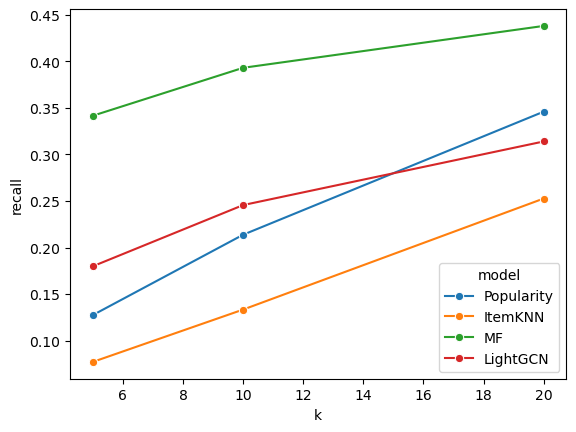

In [8]:
#7. Visualization
import seaborn as sns
sns.lineplot(
    data = all_results,
    x = "k",
    y = "recall", 
    hue = "model", 
    marker = "o"
)


<Axes: xlabel='k', ylabel='precision'>

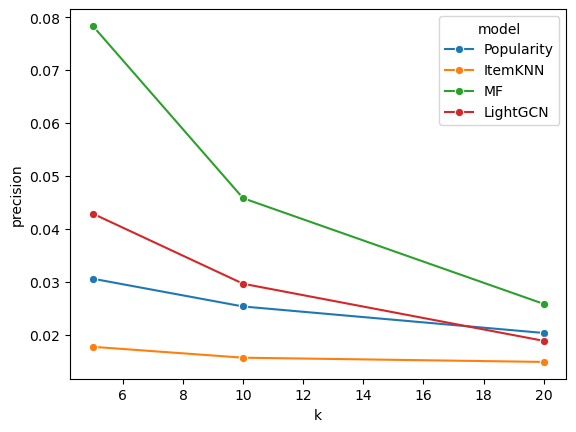

In [9]:
sns.lineplot(
    data = all_results,
    x = "k",
    y = "precision", 
    hue = "model", 
    marker = "o"
)